In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constant definitions

In [361]:
# sizes
N = 100
mem = 5

# these are the matrices representing steps and gradient changes
np.random.seed(0)
Y = np.random.randn(N, mem)
S = np.random.randn(N, mem)

# define H0
gamma = 1 # diagonal of H0
H0 = np.eye(N) * gamma

# regularizer
alpha = 1 # scaler of first obj term / regularizer

# Basic program

                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Feb 23 04:25:16 PM: Your problem has 10000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 23 04:25:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 23 04:25:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 23 04:25:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 23 04:25:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 23 04:25:16 PM: Compiling problem (target solver=SCS).
(C

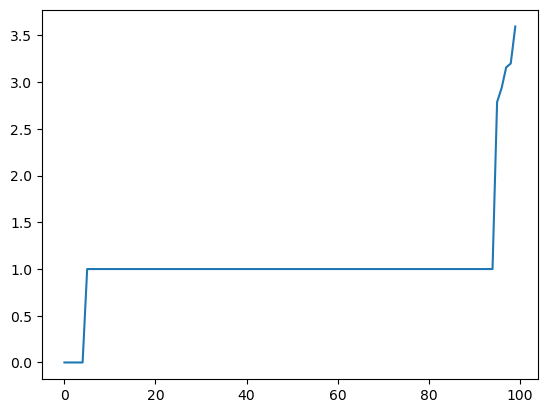

In [362]:
H = cp.Variable((N,N), PSD=True)

distance_from_h0 = cp.sum_squares(H - H0)
soft_secant_condition = cp.sum_squares(H @ Y - S)

objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(cp.Minimize(objective)).solve(
    solver='SCS',
    verbose=True,
))

plt.plot(np.linalg.eigh(H.value)[0])

# Using assumption that H is structured

In [363]:
stacked_mat = np.hstack([Y, S])

Sigma = cp.Variable((2*mem, 2*mem), symmetric=True)
structured_H = H0 + stacked_mat @ Sigma @ stacked_mat.T

distance_from_h0 = cp.sum_squares(stacked_mat @ Sigma @ stacked_mat.T)
# soft_secant_condition = cp.sum_squares(structured_H @ Y - S)
soft_secant_condition = cp.sum_squares(gamma * Y + stacked_mat @ Sigma @ (stacked_mat.T @ Y) - S)

objective = alpha * distance_from_h0 + soft_secant_condition

# print("obj value", cp.Problem(
#     cp.Minimize(objective),
#     [structured_H >> 0],
# ).solve(
#     solver='SCS',
#     verbose=True,
# ))

# print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(structured_H.value- H.value)/np.linalg.norm(structured_H.value+ H.value))

# plt.plot(np.linalg.eigh(structured_H.value)[0])

# Using SVD

In [364]:
u, s, v = np.linalg.svd(stacked_mat, full_matrices=False)
print(u.shape, s.shape, v.shape)
assert np.allclose(u @ np.diag(s) @ v, stacked_mat)

# these two are the new formulas for Y and S
assert np.allclose(u @ np.diag(s) @ v[:, :mem], Y)
assert np.allclose(u @ np.diag(s) @ v[:, mem:], S)


newSigma = cp.Variable((2*mem, 2*mem), symmetric=True)
newstructured_H = H0 + stacked_mat @ newSigma @ stacked_mat.T

# translating from above
distance_from_h0 = cp.sum_squares(np.diag(s) @ v @ newSigma @ v.T @ np.diag(s))
soft_secant_condition = cp.sum_squares(gamma * np.diag(s) @ v[:, :mem] + np.diag(s) @ v @ newSigma @ v.T @ np.diag(s) @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:])

objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[ cp.lambda_min(np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)) >= - gamma],# * np.eye(2*mem)],
    # [ np.diag(s) @ v @ newSigma @ v.T @ np.diag(s) >> - gamma * np.eye(2*mem)],
    [ newSigma >> - v.T @ np.diag(1./s) @ (gamma * np.eye(2*mem))  @ np.diag(1./s) @ v],

).solve(
    solver='SCS',
    verbose=True,
))

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))


(100, 10) (10,) (10, 10)
                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Feb 23 04:25:17 PM: Your problem has 100 variables, 100 constraints, and 0 parameters.
(CVXPY) Feb 23 04:25:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 23 04:25:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 23 04:25:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 23 04:25:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 23 04:25:17 PM: Compiling proble

In [365]:
distance_from_h0.value

array(28.2018648)

In [366]:
assert np.isclose(
    np.trace((np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)).value @ (np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)).value),
    distance_from_h0.value)

assert np.isclose(
    np.trace(np.diag(s) @ v @ newSigma.value @ (v.T @ np.diag(s) @ np.diag(s) @ v) @ newSigma.value @ v.T @ np.diag(s)),
    distance_from_h0.value)

assert np.isclose(
    np.trace(v @ newSigma.value @ (v.T @ np.diag(s**2) @ v) @ newSigma.value @ v.T @ np.diag(s**2)),
    distance_from_h0.value)

In [367]:
np.linalg.eigh(np.diag(s) @ v @ newSigma.value @ v.T @ np.diag(s))[0]

array([-1.02410802, -1.00432768, -0.99224827, -0.99087242, -0.98787103,
        1.77031025,  1.9299551 ,  2.16665606,  2.20348255,  2.60646515])

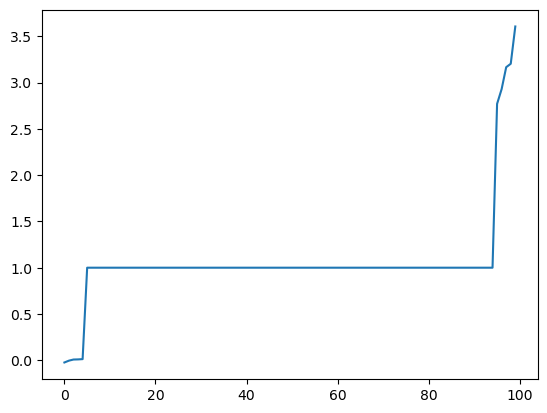

In [368]:
plt.plot(np.linalg.eigh(newstructured_H.value)[0])

# Variable transformation - careful, some CVXPY bug

In [369]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable((2*mem, 2*mem), symmetric=True)

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition = cp.sum_squares(gamma * np.diag(s) @ v[:, :mem] + Theta @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:])
soft_secant_condition = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem] + np.diag(s) @ (gamma * v[:, :mem] - v[:, mem:]))


objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    solver='SCS',
    verbose=True,
))

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))



                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Feb 23 04:25:18 PM: Your problem has 100 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 23 04:25:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 23 04:25:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 23 04:25:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 23 04:25:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 23 04:25:18 PM: Compiling problem (target solver=SCS).
(CVX

# Reshape the objective, remove symmetry/PSD

In [370]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    #symmetric=True
)


# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)  )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[cp.lambda_min(Theta) >= - gamma],
).solve(
    # solver='SCS',
    # verbose=True,
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))



obj value -1004.0137699112543
ACCURACY OF TRANSFORMATION ~ 0.22199265627433004


# YES

In [371]:
A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)
B = np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)
assert np.allclose(-np.linalg.inv(A) @ B, Theta.value.T)
assert np.allclose(Theta.value @ A, -B.T)

# Add symmetry

In [372]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)  )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[cp.lambda_min(Theta) >= - gamma],
).solve(
    # solver='SCS',
    # verbose=True,
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

obj value -994.3387767129957
ACCURACY OF TRANSFORMATION ~ 0.20261327504067003


#### Error is anti symmetric!

In [373]:
err = Theta.value @ A + B.T
assert np.allclose(err, -err.T)

#### Obtained sort of close formula

In [374]:
# Theta @ A + B.T - err = 0
# err = Theta @ A + B.T
# err = -err.T

# Theta + B.T @ Ainv - err @ Ainv = 0
# Theta + Ainv @ B - Ainv @ err.T = 0
# Theta + Ainv @ B + Ainv @ (Theta @ A + B.T) = 0
# Theta + Ainv @ (B + B.T) + Ainv @ Theta @ A = 0
# A @ Theta + (B + B.T) + Theta @ A = 0

# check it
assert np.allclose(A @ Theta.value +  (B + B.T) + Theta.value @ A, 0.)




# Great idea, this is solvable with only one extra eigendec!

In [375]:
C = np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)

assert np.allclose(A @ Theta.value +  (B + B.T) + Theta.value @ A, 0.)
# A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)

assert np.allclose(2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C, 0.)


In [376]:
new_s, V = np.linalg.eigh(C)
assert np.allclose(V @ np.diag(new_s) @ V.T, C)
assert np.allclose(2*Theta.value  + V @ np.diag(new_s) @ V.T @ Theta.value +  (B + B.T) + Theta.value @ V @ np.diag(new_s) @ V.T, 0.)
assert np.allclose(2* V.T @ Theta.value  + np.diag(new_s) @ V.T @ Theta.value +  V.T @ (B + B.T) + V.T @ Theta.value @ V @ np.diag(new_s) @ V.T, 0.)
assert np.allclose(2* V.T @ Theta.value @ V  + np.diag(new_s) @ V.T @ Theta.value @ V +  V.T @ (B + B.T) @ V + V.T @ Theta.value @ V @ np.diag(new_s), 0.)

Lambda = V.T @ Theta.value @ V
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda+  V.T @ (B + B.T) @ V + Lambda @ np.diag(new_s), 0.)


In [377]:
# plt.imshow((np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda))
# plt.colorbar()

In [378]:
SCALING_MATRIX = (np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda)
assert np.allclose((-V.T @ (B + B.T) @ V) / SCALING_MATRIX, Lambda)

#### Can we improve it? No... these transformations are not invertible

In [379]:
# # A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)
# # B = np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)

# assert np.allclose(
#     2 * Theta.value +
#     np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.value +  
#     np.diag(s) @ (
#         v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * v[:, :mem] - v[:, mem:]) @ v[:, :mem].T
#     ) @ np.diag(s) 
#     + Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s),
#     0.)

# assert np.allclose(
#     2 * np.diag(1./s) @ Theta.value @ np.diag(1./s) +
#     v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s)+  
#     (
#         v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * v[:, :mem] - v[:, mem:]) @ v[:, :mem].T
#     )
#     + np.diag(1./s) @ Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T,
#     0.)

# assert np.allclose(
#     2 * v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(1./s) +
#     v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s)+  
#     (
#          (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * np.eye(mem)) @ v[:, :mem].T
#     )
#     + v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T,
#     0.)

# # this is nice but it's a smaller set of equations, not enough
# assert np.allclose(
#     2 * v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(1./s) @ v[:, mem:] +
#     v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s) @ v[:, mem:]+  
#     (- (gamma * np.eye(3) )),
#     0.)


In [380]:
# v[:, mem:]  @ v[:, mem:].T

### PSD part 

In [381]:
# ONLY_SYMMETRIC_THETA = Theta.value
# PROJECTED_THETA = eivec @ np.diag(np.maximum(eival, -gamma)) @ eivec.T

In [382]:
# eival, eivec = np.linalg.eigh(Theta.value)
# plt.imshow(eivec.T @ Theta.value @ eivec)
# plt.colorbar()

# Add PSD

In [597]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    solver='SCS',
    eps=1e-14
    # verbose=True,
))

# reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
# newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
newstructured_H = H0 + u @ Theta @ u.T

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

obj value -927.9448664997323
ACCURACY OF TRANSFORMATION ~ 4.202839326931374e-06


# DR: remove regularization part of objective, truncate at ~10 iters

In [646]:
np.linalg.eigh(Theta.value)[0]

def PSD_PROJECT(theta):
    eival, eivec = np.linalg.eigh(theta)
    print('EIVALS', eival)
    return eivec @ np.diag(np.maximum(eival, -1.)) @ eivec.T

assert np.allclose(PSD_PROJECT(Theta.value), Theta.value)

S_MULTIPLIER = 100 * 2*mem/(np.linalg.norm(s))
GAMMA=0.5
def quadratic_proximal(theta, GAMMA=0.5):
    

    theta_var = cp.Variable(
        (2*mem, 2*mem), 
        symmetric=True)

    # distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ theta_var @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
    distance_from_theta = cp.sum_squares(theta_var - theta)
    soft_secant_condition1 = cp.sum_squares(theta_var @ np.diag(s*S_MULTIPLIER) @ v[:, :mem])
    soft_secant_condition2 = 2 * cp.trace(np.diag(s*S_MULTIPLIER) @ theta_var @ np.diag(s*S_MULTIPLIER) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T )

    # objective = alpha * distance_from_h0 + GAMMA * distance_from_theta + soft_secant_condition1 + soft_secant_condition2
    objective = GAMMA * distance_from_theta + soft_secant_condition1 + soft_secant_condition2

    cp.Problem(cp.Minimize(objective)).solve(solver='OSQP')
    return theta_var.value

#assert max(np.linalg.eigh(quadratic_proximal(Theta.value) - Theta.value)[0]) < 0

    

EIVALS [-1.         -1.         -1.         -1.         -1.          1.78697894
  1.9383058   2.1590461   2.19991493  2.59619472]


In [647]:
#100 * 2*mem/(np.linalg.norm(s))

In [648]:
theta = np.zeros((2*mem,2*mem))

for i in range(100):
    pi1 = PSD_PROJECT(theta)

    ## evaluate quality
    H = np.eye(N) + u @ pi1 @ u.T
    print(np.linalg.norm(H @ Y - S)**2)
    
    pi2 = quadratic_proximal(2 * pi1 - theta, GAMMA=0.5)
    theta += pi2 - pi1 
    # if np.linalg.eigh(theta)[0][-1] > 8:
    #     print('iter', i)
    #     break
    # print(np.linalg.eigh(theta)[0][-1])

result = PSD_PROJECT(theta)


EIVALS [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1014.3491397873245
EIVALS [-1.88159853 -1.70763315 -1.57836052 -1.53129927 -1.46437497  0.4602253
  0.47814809  0.59114143  0.67907803  0.69530265]
150.21512903896186
EIVALS [-2.65669195 -2.32374678 -2.07620553 -1.99725079 -1.87144092  0.64295508
  0.67757608  0.86678492  0.93264123  1.03721305]
130.39320462431658
EIVALS [-3.3474027  -2.86337114 -2.51093226 -2.4003071  -2.222383    0.85636703
  0.91494402  1.1632526   1.23190264  1.42253996]
112.66632900690425
EIVALS [-3.97718    -3.34560056 -2.90007539 -2.75231569 -2.52520887  1.08035006
  1.16392825  1.44990746  1.5491638   1.81160779]
97.83664336863474
EIVALS [-4.56283181 -3.78513906 -3.25520895 -3.06559965 -2.78845114  1.30398922
  1.41211556  1.72326384  1.86409523  2.1898503 ]
85.6669808809146
EIVALS [-5.11548096 -4.19215694 -3.58389918 -3.34957795 -3.01933047  1.5221496
  1.6539683   1.98312821  2.16852583  2.5525484 ]
75.7542939517351
EIVALS [-5.64251827 -4.5736281  -3.89138482 -3.61079547

In [649]:
theta = np.zeros((2*mem,2*mem))

for i in range(10):
    pi1 = PSD_PROJECT(theta)

    ## evaluate quality
    H = np.eye(N) + u @ pi1 @ u.T
    print(np.linalg.norm(H @ Y - S)**2)
    
    pi2 = quadratic_proximal(2 * pi1 - theta, GAMMA=0.05)
    theta += pi2 - pi1 
    # if np.linalg.eigh(theta)[0][-1] > 8:
    #     print('iter', i)
    #     break
    # print(np.linalg.eigh(theta)[0][-1])

result = PSD_PROJECT(theta)


EIVALS [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1014.3491397873245
EIVALS [-1.87877313 -1.70700617 -1.57645676 -1.52944852 -1.46377747  0.46186099
  0.47877057  0.59237685  0.68650796  0.70461848]
149.69098319635802
EIVALS [-2.65279319 -2.32287112 -2.07445115 -1.99334371 -1.87043765  0.64402905
  0.67879286  0.8670185   0.93853719  1.04264272]
130.05531884994429
EIVALS [-3.34507007 -2.86297816 -2.51080171 -2.39618183 -2.22194088  0.8559645
  0.91541437  1.15827702  1.23008779  1.41535674]
112.6556554080819
EIVALS [-3.97849432 -3.34638227 -2.90170675 -2.75035161 -2.52686592  1.07769351
  1.16240526  1.43008857  1.54269204  1.78544246]
98.15154241382061
EIVALS [-4.56931514 -3.78768805 -3.25840005 -3.06754433 -2.79409471  1.29832171
  1.40737553  1.68253186  1.85398361  2.13976184]
86.27092416156883
EIVALS [-5.12830146 -4.19698701 -3.58851297 -3.3564771  -3.030988    1.51268821
  1.64464304  1.91774238  2.15437072  2.47432421]
76.60332118925253
EIVALS [-5.66263731 -4.58119902 -3.89737957 -3.623266

In [657]:
# def quadratic_proximal1(theta0):
#     theta_var = cp.Variable(
#         (2*mem, 2*mem), 
#         symmetric=True)

#     distance_from_theta = cp.sum_squares(theta_var - theta)
#     soft_secant_condition1 = cp.sum_squares(theta_var @ np.diag(s*S_MULTIPLIER) @ v[:, :mem])
#     soft_secant_condition2 = 2 * cp.trace(np.diag(s*S_MULTIPLIER) @ theta_var @ np.diag(s*S_MULTIPLIER) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T )

#     objective = GAMMA * distance_from_theta + soft_secant_condition1 + soft_secant_condition2

#     cp.Problem(cp.Minimize(objective)).solve()#solver='SCS', eps=1e-14)
#     return theta_var.value

# FINAL WORK, PROJECTION ON LINSPACE

In [658]:
theta0 = np.random.randn(2*mem, 2*mem)
theta0 = (theta0.T @ theta0) * 10

newA = GAMMA * np.eye(2*mem) + np.diag(s*S_MULTIPLIER) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s*S_MULTIPLIER)
newC = np.diag(s*S_MULTIPLIER) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s*S_MULTIPLIER)
newB = np.diag(s*S_MULTIPLIER) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s*S_MULTIPLIER) - GAMMA * theta0
# assert np.allclose(newA @ quadratic_proximal1(theta0) +  (newB + newB.T) + quadratic_proximal1(theta0) @ newA, 0.)
assert np.linalg.norm(2 * GAMMA *quadratic_proximal(theta0) + newC @ quadratic_proximal(theta0) +  (newB + newB.T) + quadratic_proximal(theta0) @ newC) < 1e-4


new_eival, new_eivec = np.linalg.eigh(newC)
assert np.allclose(new_eivec @ np.diag(new_eival) @ new_eivec.T, newC)

assert np.linalg.norm(2 * GAMMA *quadratic_proximal(theta0) + new_eivec @ np.diag(new_eival) @ new_eivec.T @ quadratic_proximal(theta0) +  (newB + newB.T) + quadratic_proximal(theta0) @ new_eivec @ np.diag(new_eival) @ new_eivec.T) < 1e-4

assert np.linalg.norm(2 * GAMMA * new_eivec.T @ quadratic_proximal(theta0) @ new_eivec
                      + np.diag(new_eival) @ new_eivec.T @ quadratic_proximal(theta0) @ new_eivec 
                      + new_eivec.T @ (newB + newB.T) @ new_eivec 
                      + new_eivec.T @ quadratic_proximal(theta0) @ new_eivec @ np.diag(new_eival) ) < 1e-4

NEWSCALING_MATRIX = (np.ones_like(theta0) * new_eival).T + np.ones_like(theta0) * new_eival + 2 * np.ones_like(theta0) * GAMMA

(new_eivec.T @ (newB + newB.T) @ new_eivec) / NEWSCALING_MATRIX + new_eivec.T @ quadratic_proximal1(theta0) @ new_eivec 

# assert np.allclose(newA @ quadratic_proximal1(theta0) +  (newB + newB.T) + quadratic_proximal1(theta0) @ newA, 0.)

assert np.allclose(
    quadratic_proximal(theta0),
    -new_eivec @ ((new_eivec.T @ (newB + newB.T) @ new_eivec) / NEWSCALING_MATRIX) @ new_eivec.T
)


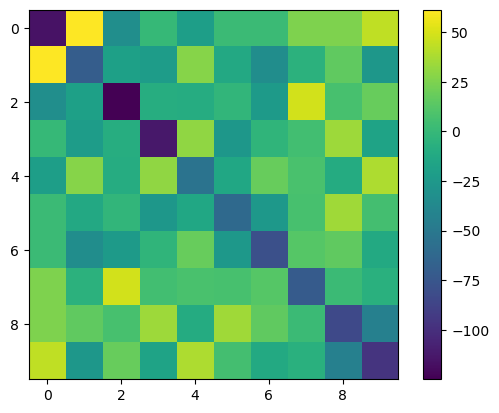

In [608]:
plt.imshow(GAMMA *quadratic_proximal1(theta0) + newC @ quadratic_proximal1(theta0) +  (newB + newB.T) + quadratic_proximal1(theta0) @ newC)
plt.colorbar()

In [609]:
assert np.allclose(
    quadratic_proximal(np.zeros((2*mem, 2*mem))),
    quadratic_proximal1(np.zeros((2*mem, 2*mem))))

AssertionError: 

In [613]:
theta = np.zeros((2*mem,2*mem))

for i in range(10):
    pi1 = PSD_PROJECT(theta)

    ## evaluate quality
    H = np.eye(N) + u @ pi1 @ u.T
    print(np.linalg.norm(H @ Y - S)**2)
    
    pi2 = quadratic_proximal(2 * pi1 - theta)
    theta += pi2 - pi1 
    # if np.linalg.eigh(theta)[0][-1] > 8:
    #     print('iter', i)
    #     break
    # print(np.linalg.eigh(theta)[0][-1])

result = PSD_PROJECT(theta)


EIVALS [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1014.3491397873245
EIVALS [-1.88159853 -1.70763315 -1.57836052 -1.53129927 -1.46437497  0.4602253
  0.47814809  0.59114143  0.67907803  0.69530265]
150.21512903896186
EIVALS [-2.65669195 -2.32374678 -2.07620553 -1.99725079 -1.87144092  0.64295508
  0.67757608  0.86678492  0.93264123  1.03721305]
130.39320462431658
EIVALS [-3.3474027  -2.86337114 -2.51093226 -2.4003071  -2.222383    0.85636703
  0.91494402  1.1632526   1.23190264  1.42253996]
112.66632900690425
EIVALS [-3.97718    -3.34560056 -2.90007539 -2.75231569 -2.52520887  1.08035006
  1.16392825  1.44990746  1.5491638   1.81160779]
97.83664336863474
EIVALS [-4.56283181 -3.78513906 -3.25520895 -3.06559965 -2.78845114  1.30398922
  1.41211556  1.72326384  1.86409523  2.1898503 ]
85.6669808809146
EIVALS [-5.11548096 -4.19215694 -3.58389918 -3.34957795 -3.01933047  1.5221496
  1.6539683   1.98312821  2.16852583  2.5525484 ]
75.7542939517351
EIVALS [-5.64251827 -4.5736281  -3.89138482 -3.61079547

In [520]:
# result

array([[ 1.01390518e+00, -9.80549485e-01,  8.10907236e-01,
        -1.75159878e-01, -8.28075756e-01,  3.24913170e-01,
         3.98401372e-01, -3.14250491e-01,  9.60413584e-01,
        -4.76709840e-01],
       [-9.80549485e-01,  7.34848778e-01, -8.12691122e-01,
        -1.07126988e+00,  6.67641810e-01,  2.19870541e-01,
         3.99625263e-01, -4.15268918e-01,  6.64471296e-01,
        -5.27055709e-01],
       [ 8.10907236e-01, -8.12691122e-01, -2.40836330e-01,
        -2.22119630e-02, -4.86677037e-01,  5.37557517e-04,
         1.21592621e-01, -6.20789992e-01, -1.56988046e-01,
         6.95501288e-01],
       [-1.75159878e-01, -1.07126988e+00, -2.22119630e-02,
         1.05904783e+00,  3.16109696e-01,  1.34909164e-01,
        -6.84564165e-02,  1.77665918e+00, -4.91478996e-01,
         7.36043525e-01],
       [-8.28075756e-01,  6.67641810e-01, -4.86677037e-01,
         3.16109696e-01, -2.58867807e-01,  4.29365626e-01,
         7.41424375e-02,  4.04888973e-01,  3.27277397e-01,
         5.

In [483]:
reconstructed_Sigma = v.T @ np.diag(1./s) @ result @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
newstructured_H1 = H0 + u  @ result @ u.T
assert np.allclose(newstructured_H, newstructured_H1)
s

array([11.6810677 , 11.31221525, 10.68110585, 10.51361038, 10.05537111,
        9.55365885,  9.32427011,  8.99286775,  8.29657204,  7.63003063])

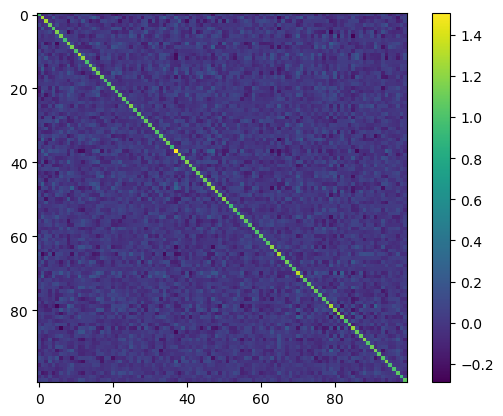

In [484]:
plt.imshow(newstructured_H1)
plt.colorbar()

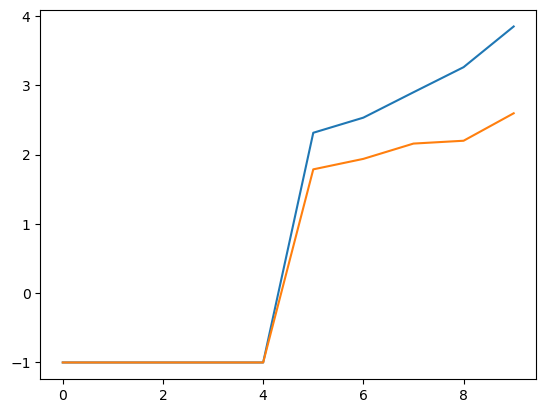

In [485]:
plt.plot(np.linalg.eigh(result)[0])
plt.plot(np.linalg.eigh(Theta.value)[0])


In [490]:
s*S_MULTIPLIER

array([373.84774109, 362.04277071, 341.84437535, 336.48375227,
       321.81799391, 305.76090051, 298.41940888, 287.81301337,
       265.52835692, 244.19597476])

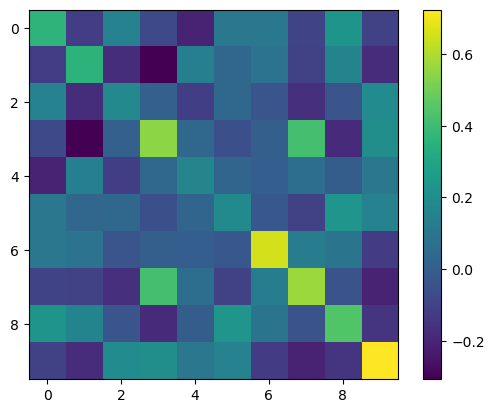

In [487]:
plt.imshow((result-Theta.value))
plt.colorbar()

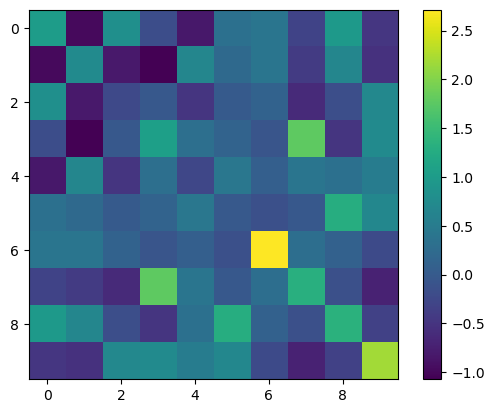

In [488]:
plt.imshow(result)
plt.colorbar()

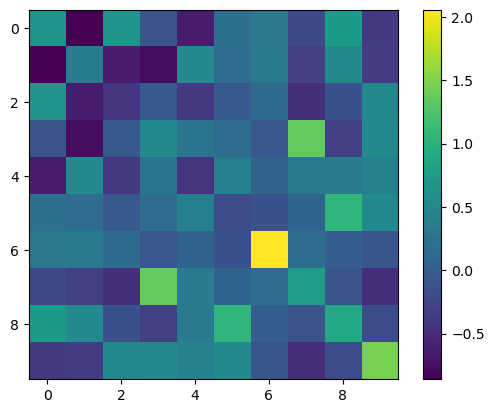

In [489]:
plt.imshow(Theta.value)
plt.colorbar()

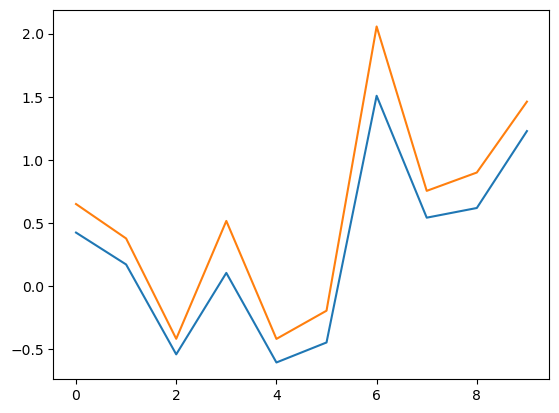

In [450]:
plt.plot(np.diag(result))
plt.plot(np.diag(Theta.value))

# Check with KKT system of only symmetric

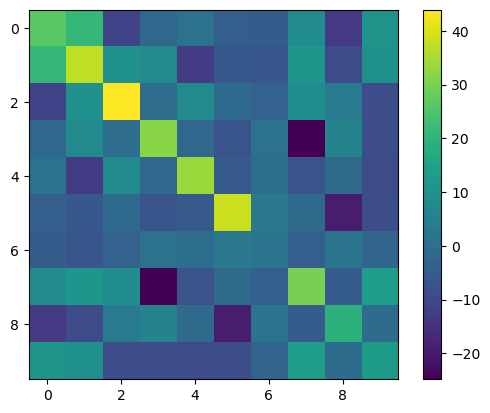

In [390]:
# this was zero with symm
Dual = 2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C
plt.imshow(Dual)
plt.colorbar()


# Great, that's looks like the KKT change we need 

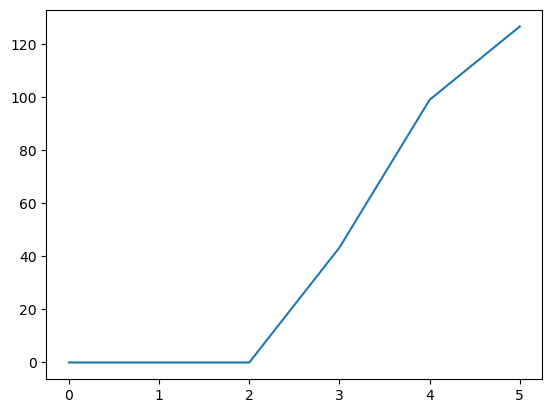

In [234]:
plt.plot(np.linalg.eigh(Dual)[0])
# plt.plot(np.linalg.eigh(ONLY_SYMMETRIC_THETA)[0])

# smaller than -1 eigenspace of original rhs

In [235]:
# # only symm RSH
# old_rhs = (-V.T @ (B + B.T) @ V) / SCALING_MATRIX

# eival_d, eivec_d = np.linalg.eigh(old_rhs)
# assert np.allclose(eivec_d @ np.diag(eival_d) @ eivec_d.T, old_rhs)
# orig_rhs_nullspace_proj = eivec_d @ np.diag((eival_d <= -1) * 1) @ eivec_d.T
# eival_d

In [236]:
# plt.plot(np.linalg.eigh(Dual)[0])
# plt.plot(np.linalg.eigh(orig_rhs_nullspace_proj @ Dual @ orig_rhs_nullspace_proj)[0])

In [237]:
# plt.plot(np.linalg.eigh(Theta.value)[0])
# plt.plot(np.linalg.eigh(orig_rhs_nullspace_proj @ Theta.value @ orig_rhs_nullspace_proj)[0])

In [238]:
# eival_d, eivec_d = np.linalg.eigh(Dual)
# assert np.allclose(eivec_d @ np.diag(eival_d) @ eivec_d.T, Dual)
# dual_nullspace_proj = eivec_d @ np.diag((eival_d <= 1e-6) * 1) @ eivec_d.T

# # only symm RSH
# old_rhs = (-V.T @ (B + B.T) @ V) / SCALING_MATRIX

# # plt.imshow(dual_nullspace_proj @ old_rhs @ dual_nullspace_proj)

# plt.plot(np.linalg.eigh(dual_nullspace_proj @ old_rhs @ dual_nullspace_proj)[0])

In [32]:
# plt.plot(np.linalg.eigh(dual_nullspace_proj @ Theta.value @ dual_nullspace_proj)[0])

# YES! the condition that I though

In [491]:
assert np.allclose(Dual @ (Theta.value + np.eye(2*mem)), 0.)

# So the KKT conditions are like this

In [492]:
# 2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C = Dual
# Dual + Dual @ Theta.value = 0
# Dual >> 0

In [493]:
new_s, V = np.linalg.eigh(C)
Lambda = V.T @ Theta.value @ V
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), V.T @ (Dual) @ V - V.T @ (B + B.T) @ V)
assert np.allclose(Dual + Dual @ Theta.value, 0)
rotated_dual = V.T @ (Dual) @ V
rotated_const = V.T @ (B + B.T) @ V

assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), rotated_dual - rotated_const)
assert np.allclose(rotated_dual +rotated_dual @ Lambda, 0)

SCALING_MATRIX = (np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda)

# Here we are
assert np.allclose(SCALING_MATRIX * Lambda, rotated_dual - rotated_const)
assert np.allclose(rotated_dual +rotated_dual @ Lambda, 0)
assert np.isclose(np.min(np.linalg.eigh(rotated_dual)[0]), 0.)


In [494]:
myeival, myeivec =np.linalg.eigh(rotated_const/SCALING_MATRIX)

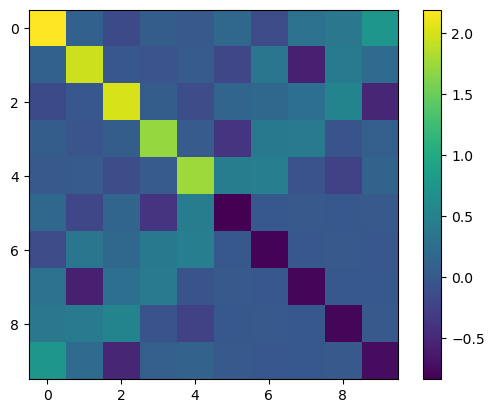

In [495]:
plt.imshow(myeivec.T @ Lambda @ myeivec)
plt.colorbar()

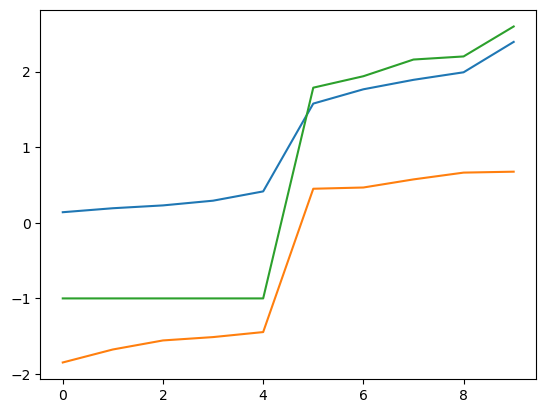

In [496]:
plt.plot(np.linalg.eigh(rotated_dual/SCALING_MATRIX)[0])
plt.plot(np.linalg.eigh(-rotated_const/SCALING_MATRIX)[0])
# plt.plot(np.linalg.eigh(SCALING_MATRIX * Lambda)[0])
plt.plot(np.linalg.eigh(Lambda)[0])


## Solve these!

In [497]:
# Here we are
# assert np.allclose(np.sqrt(SCALING_MATRIX) * Lambda * np.sqrt(SCALING_MATRIX) - rotated_dual, - rotated_const)
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), rotated_dual - rotated_const)
assert np.allclose(2 * rotated_dual + rotated_dual @ Lambda + Lambda @ rotated_dual, 0)
assert np.min(np.linalg.eigh(rotated_dual)[0]) >= -1e-6
assert np.min(np.linalg.eigh(Lambda)[0]) >= -1 -1e-6


# If I use this I only need first equation above

In [498]:
def spd_proj(sym_mat):
    eival, eivec = np.linalg.eigh(sym_mat)
    return eivec @ np.diag(np.maximum(eival, 0.)) @ eivec.T

pridual = Lambda + np.eye(2*mem) - rotated_dual

assert(np.allclose(spd_proj(pridual) -  np.eye(2*mem),  Lambda))
assert(np.allclose(spd_proj(pridual) - pridual,  rotated_dual))

### Let's try to rewrite it?

In [499]:
assert np.allclose(
    2 * (spd_proj(pridual) -  np.eye(2*mem)) 
    + np.diag(new_s) @ (spd_proj(pridual) -  np.eye(2*mem)) 
    + (spd_proj(pridual) -  np.eye(2*mem)) @ np.diag(new_s),
    spd_proj(pridual) - pridual - rotated_const)


In [500]:
assert np.allclose(
    + pridual
    + spd_proj(pridual)
    + np.diag(new_s) @ spd_proj(pridual) 
    + spd_proj(pridual) @ np.diag(new_s),
    
    2 * np.eye(2*mem)  - rotated_const + 2 * np.diag(new_s) )


## This seems the shortest I can make it...

In [501]:
NEW_SCALING_MATRIX = (
    np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + np.ones_like(Lambda)

assert np.allclose(
    + pridual
    + spd_proj(pridual) * NEW_SCALING_MATRIX,
    2 * np.eye(2*mem)  - rotated_const + 2 * np.diag(new_s) )



In [502]:
RHS = 2 * np.eye(2*mem)  - rotated_const + 2 * np.diag(new_s)

assert np.allclose(pridual + spd_proj(pridual) * NEW_SCALING_MATRIX, RHS)

## Iterative process?

96203.74824086012
45566.93328350381


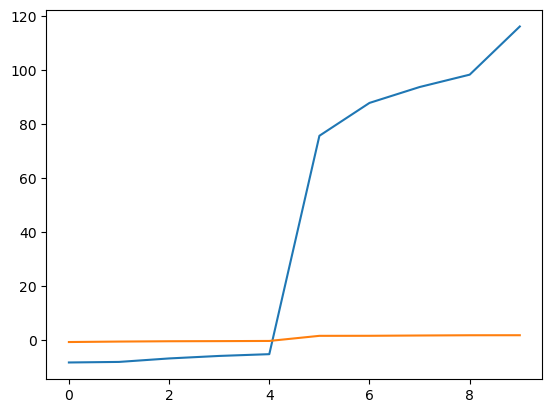

In [503]:
init_sol = RHS / (NEW_SCALING_MATRIX+1.) # important, +1

print(np.linalg.norm(RHS)**2)
err = init_sol + spd_proj(init_sol) * NEW_SCALING_MATRIX - RHS
print(np.linalg.norm(err)**2)

plt.plot(np.linalg.eigh(err)[0])
plt.plot(np.linalg.eigh(init_sol)[0])

# At this point; best solution is DR splitting on original program; one PSD proj per iteration :)

In [504]:
zio = np.random.randn(20,20)
zia = zio.T @ zio

In [505]:
%timeit np.linalg.eigh(zia)

20.1 μs ± 391 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [506]:
%timeit zio @ zio

906 ns ± 11 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [507]:
%timeit zio * zio

252 ns ± 1.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# PSD proj dominates; on fast processor we are at ~20mus per iter; if we do 5 it's 1ms per iteration; probably too slow

# If this analysis is correct; only few steps of 2019 refinement/gradient descent necessary to get decent solution; b/c pos/neg eigenspaces of init_sol almost coincide w/ pos/neg eigenspaces of real sol

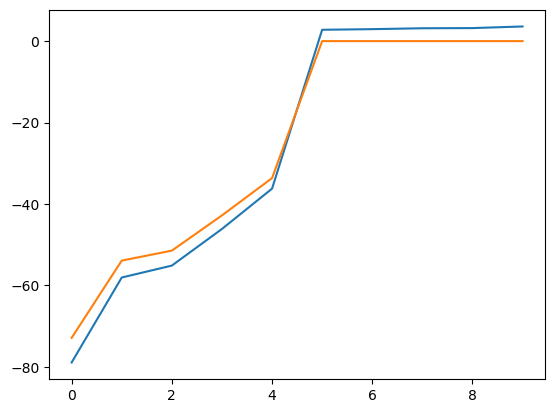

In [508]:
eival_init, eivec_init = np.linalg.eigh(init_sol)
assert np.allclose(eivec_init @ np.diag(eival_init) @ eivec_init.T, init_sol)
init_sol_negspace_proj = eivec_init @ np.diag((eival_init <= 1e-6) * 1) @ eivec_init.T

plt.plot(np.linalg.eigh(pridual)[0])
plt.plot(np.linalg.eigh(init_sol_negspace_proj @ pridual @ init_sol_negspace_proj)[0])

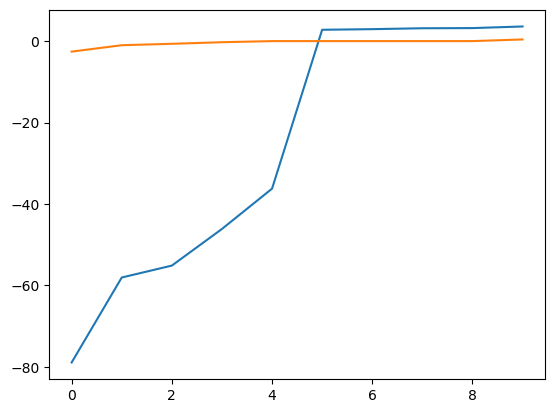

In [509]:
init_sol_posspace_proj = eivec_init @ np.diag((eival_init >= -1e-6) * 1) @ eivec_init.T

plt.plot(np.linalg.eigh(pridual)[0])
plt.plot(np.linalg.eigh(init_sol_posspace_proj @ pridual @ init_sol_posspace_proj)[0])

## Opposite, check eigenstructure of init sol on real sol's; this one is exact, same eigenspaces! But of course we don't know it

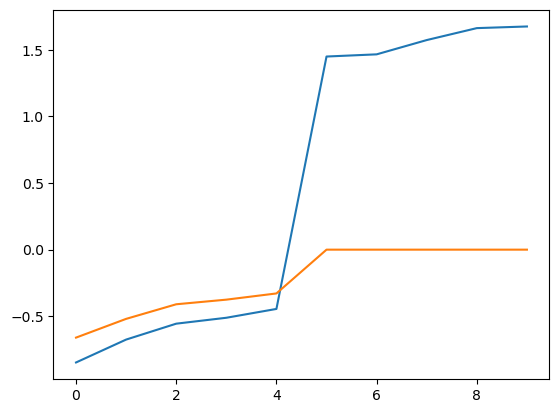

In [510]:
eival_pridual, eivec_pridual = np.linalg.eigh(pridual)
assert np.allclose(eivec_pridual @ np.diag(eival_pridual) @ eivec_pridual.T, pridual)
pridual_negspace_proj = eivec_pridual @ np.diag((eival_pridual <= -1+1e-4) * 1) @ eivec_pridual.T

plt.plot(np.linalg.eigh(init_sol)[0])
plt.plot(np.linalg.eigh(pridual_negspace_proj @ init_sol @ pridual_negspace_proj)[0])

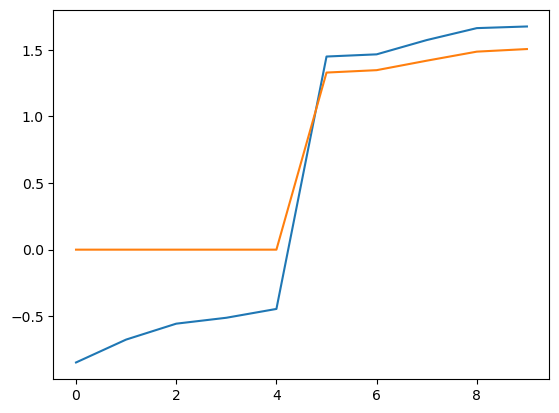

In [511]:
eival_pridual, eivec_pridual = np.linalg.eigh(pridual)
assert np.allclose(eivec_pridual @ np.diag(eival_pridual) @ eivec_pridual.T, pridual)
pridual_posspace_proj = eivec_pridual @ np.diag((eival_pridual >= -1-1e-4) * 1) @ eivec_pridual.T

plt.plot(np.linalg.eigh(init_sol)[0])
plt.plot(np.linalg.eigh(pridual_posspace_proj @ init_sol @ pridual_posspace_proj)[0])

# Easier; we can use the eigendec of the "init sol" and simply optimize on the eigenvals; maybe it's enough of an approx solution

In [512]:
assert np.allclose(pridual + spd_proj(pridual) * NEW_SCALING_MATRIX, RHS)
init_sol = RHS / (NEW_SCALING_MATRIX+1.) # important, +1

eival_init, eivec_init = np.linalg.eigh(init_sol)
assert np.allclose(eivec_init @ np.diag(eival_init) @ eivec_init.T, init_sol)

num_neg_eivals = sum(eival_init<0)
variable_eigenvals = cp.Variable(2*mem)

my_pridual = eivec_init @ cp.diag(variable_eigenvals) @ eivec_init.T
my_sol = (
    my_pridual
    + cp.multiply(eivec_init[:, num_neg_eivals:] @ cp.diag(variable_eigenvals[num_neg_eivals:]) @ eivec_init[:, num_neg_eivals:].T, NEW_SCALING_MATRIX))

obj = cp.Minimize(cp.sum_squares(my_sol - RHS))

variable_eigenvals.value = np.zeros(2*mem)
print(obj.value)
variable_eigenvals.value = eival_init
print(obj.value)
print(cp.Problem(obj).solve())

96203.74824086014
45566.933283503815
3367.616070691954


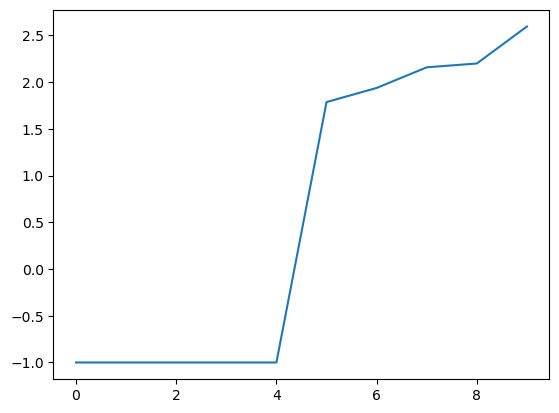

In [513]:
assert(np.allclose(spd_proj(pridual) -  np.eye(2*mem),  Lambda))
plt.plot(np.linalg.eigh(Lambda)[0])

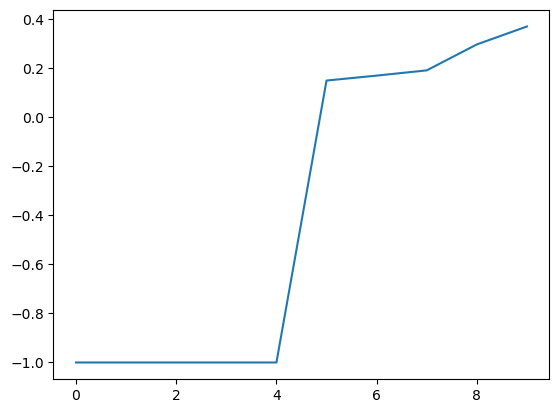

In [514]:
my_lambda = spd_proj(my_pridual.value) -  np.eye(2*mem)
plt.plot(np.linalg.eigh(my_lambda)[0])

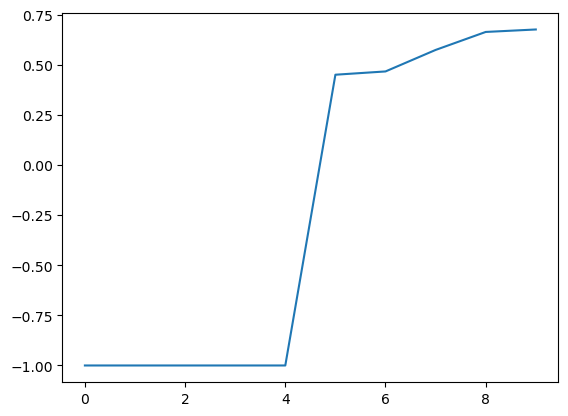

In [515]:
variable_eigenvals.value = eival_init
init_lambda = spd_proj(my_pridual.value) -  np.eye(2*mem)
plt.plot(np.linalg.eigh(init_lambda)[0])

# No it's very bad; basically worse than projection of init sol

In [516]:
# plt.imshow(Lambda)
# plt.colorbar()

In [517]:
# plt.imshow(my_lambda)
# plt.colorbar()

# END

In [51]:
raise Exception

Exception: 

In [ ]:
np.linalg.eigh(rotated_dual)[0], np.linalg.eigh(Lambda + np.eye(2*mem))[0]

#### Common diagonalizer of Lambda and rotated dual

In [ ]:
testV = np.linalg.eigh(rotated_dual + Lambda)[1]

dua_diag = np.diag(testV.T @ rotated_dual @ testV )
lam_diag = np.diag(testV.T @ Lambda @ testV )

rotated_rotated_s = testV.T @ np.diag(new_s) @ testV
rotated_rotated_const = testV.T @ rotated_const @ testV

# WE GET TO THIS FORM
assert np.allclose(2* np.diag(lam_diag) + rotated_rotated_s @ np.diag(lam_diag) + np.diag(lam_diag) @ rotated_rotated_s, np.diag(dua_diag) - rotated_rotated_const)
assert np.allclose(dua_diag * (lam_diag + 1), 0.)
assert np.isclose(np.min(dua_diag), 0.)



In [ ]:
plt.plot(np.diag( testV.T @ (rotated_dual + Lambda) @ testV ))
plt.plot(np.diag(testV.T @ (rotated_dual) @ testV) -1.)
plt.plot(np.diag(testV.T @ (Lambda) @ testV))


In [ ]:
plt.imshow(rotated_rotated_s)

In [ ]:
# testV = np.linalg.eigh(rotated_dual + Lambda)[1]
# #plt.imshow(
# testV @ (rotated_const/ SCALING_MATRIX) @ testV.T
# #)#, testV @ rotated_const @ testV.T

In [ ]:
testV = np.linalg.eigh(ro / SCALING_MATRIX)[1]

In [ ]:
# testV = np.linalg.eigh(rotated_const / SCALING_MATRIX)[1]
# testV.T @ rotated_dual @ testV, testV @ rotated_dual @ testV.T

In [ ]:
# testV = np.linalg.eigh(rotated_const)[1]
# testV.T @ rotated_dual @ testV, testV @ rotated_dual @ testV.T

# End

In [ ]:
raise Exception

In [ ]:
plt.imshow(old_kkt @ (Theta.value + np.eye(2*mem)))
plt.colorbar()

In [ ]:
np.diag(myV.T @ Theta.value @ myV)

In [ ]:
plt.imshow(myV.T @ Theta.value @ myV)
plt.colorbar()

In [ ]:
plt.plot(np.linalg.eigh(Theta.value + np.eye(2 * mem))[0])


In [ ]:
old_kkt @ Theta.value

### Sadly not trivial projection

In [ ]:
# #plt.imshow(
# eivec.T @ Theta.value @ eivec#)
# #plt.colorbar()

In [ ]:
objective.value , distance_from_h0.value , soft_secant_condition1.value , soft_secant_condition2.value

#### Using projected theta gives worse obj value

In [ ]:
Theta.value = PROJECTED_THETA
objective.value , distance_from_h0.value , soft_secant_condition1.value , soft_secant_condition2.value

# Reshape objective

In [ ]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    # symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * gamma * cp.trace( v[:, :mem].T @ np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition3 = -2 * cp.trace( v[:, mem:].T @ np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem] )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2 + soft_secant_condition3

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    solver='CLARABEL',
    # verbose=True,
    # eps=1e-14
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

In [ ]:
soft_secant_condition1.value

In [ ]:
cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.T).value

In [ ]:
v[:, :mem].T @ v[:, :mem]

In [ ]:
v[:, :mem] @ v[:, :mem].T

In [ ]:
v[:, :mem].T @ v[:, :mem]

In [ ]:
v[:, :mem] @ v[:, mem:].T

In [ ]:
raise Exception

In [ ]:
#assert np.isclose
(
    cp.sum_squares(
        + gamma * np.diag(s) @ v[:, :mem] 
        + Theta @ np.diag(s) @ v[:, :mem] 
        - np.diag(s) @ v[:, mem:]
    ).value,

    cp.trace(
        + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
        + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
        - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) * gamma
        
        + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta
        + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta
        - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) @ Theta
        
        - gamma * np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
        - Theta @ np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
        + np.diag(s) @ v[:, mem:] @ v[:, mem:].T @ np.diag(s)
    ).value
)

In [ ]:
# cp.trace(gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
#     + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
#     - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) * gamma
#     + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ Theta
#     + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ Theta
#     - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ Theta
#     - gamma * np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
#     - Theta @ np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
#     + np.diag(s) @ v[:, mem:] @ v[:, mem:].T @ np.diag(s)
# ).value/2.

In [ ]:
np.linalg.eigh(Theta.value)[0]

In [ ]:
(gamma * np.diag(s) @ v[:, :mem] + Theta @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:]).value

In [ ]:
plt.plot(np.linalg.eigh(Theta.value)[0])